In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse RBS data from Reis et al. 2020

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')

import re
from common import count_ARN_motifs, count_AAN_motifs, count_ARNn


top_dir = os.path.join('data', '22_analyse_RBS_data_Reis')
fn_1014IC = os.path.join('data', 'RBS_Calculator', 'sb0c00394_si_002.xlsx')
fn_FS = os.path.join('data', 'RBS_Calculator', 'sb0c00394_si_003.xlsx')
excel_file_IC = pd.ExcelFile(fn_1014IC)
excel_file_FS = pd.ExcelFile(fn_FS)
dataset_names = ['1014IC', 'FS']
name_sheets = list(set(excel_file_IC.sheet_names + excel_file_FS.sheet_names))
name_sheets

['RBS Calculator v1.0',
 'FS',
 'RBS Calculator v1.1',
 'Statistics',
 'RBS Designer',
 '1014IC',
 'RBS Calculator v2.1',
 'EMOPEC',
 'RBS Calculator v2.0',
 'UTR Designer']

In [19]:
def load_df(excel_file, sheet_name_proteins):
    df = pd.concat([excel_file.parse(sheet_name_proteins, index_col=0),
                    excel_file.parse('RBS Calculator v2.1', index_col=0)], axis=1)
    df = df.loc[:, ~df.T.duplicated()]
    df = df.rename(columns={'PROT.MEAN': 'Mean protein (fluo)'})
    df['Dataset source'] = sheet_name_proteins
    df['log Mean protein (fluo)'] = np.log10(df['Mean protein (fluo)'])
    # df_aux = excel_file.parse(name_sheets[1], index_col=0)
    # df['used_mRNA_sequence'] = df_aux['used_mRNA_sequence']
    df_aux = excel_file.parse('RBS Calculator v2.0', index_col=0)
    df['used_mRNA_sequence'] = df_aux['used_mRNA_sequence']
    df['predicted_5pUTR_2.0'] = df_aux['predicted_5pUTR']
    df['predicted_CDS_2.0'] = df_aux['predicted_CDS']
    df['TIR'] = df_aux['TIR']
    df['Actual protein / predicted TIR'] = np.log10(df['Mean protein (fluo)']) / np.log10(df['TIR'])
    # del df_aux

    df = df[df['used_mRNA_sequence'].apply(lambda x: type(x) == str)]
    df = df[df['predicted_5pUTR_2.0'].apply(lambda x: type(x) == str)]

    # df['ARN count'] = df['used_mRNA_sequence'].apply(count_ARN_motifs)
    # df['AAN count'] = df['used_mRNA_sequence'].apply(count_AAN_motifs)
    df = df[~df['5pUTR'].isna()]
    df["ARN count (5' UTR)"] = df['5pUTR'].apply(count_ARN_motifs)
    df["AAN count (5' UTR)"] = df['5pUTR'].apply(count_AAN_motifs)
    df["ARNn count (5' UTR)"] = df['5pUTR'].apply(count_ARNn)

    df["log(yError)"] = np.log10(df["yError"])  # avoid log(0)

    print("\nShape of dataframe:", df.shape)
    
    return df
    
    
df_IC = load_df(excel_file_IC, '1014IC')
df_FS = load_df(excel_file_FS, 'FS')
df = pd.concat([df_IC, df_FS], axis=0)


Shape of dataframe: (946, 55)

Shape of dataframe: (16779, 78)


# ARN motifs vs. predicted DG

In [20]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# sns.scatterplot(data=df, x="ARNn count (5' UTR)", y='Mean protein (fluo)', 
#                 hue='dG_total', alpha=0.5, ax=axs[0])
# axs[0].set_yscale('log')
# sns.violinplot(data=df, x="ARNn count (5' UTR)", y='log Mean protein (fluo)', 
#                alpha=0.5, ax=axs[1])
# # axs[1].set_yscale('log')
# plt.suptitle("Actual protein expression vs. (ARN)n motif")
# # sns.scatterplot(data=df, x="AAN count (5' UTR)", y='dG_total', label='AAN', alpha=0.5)

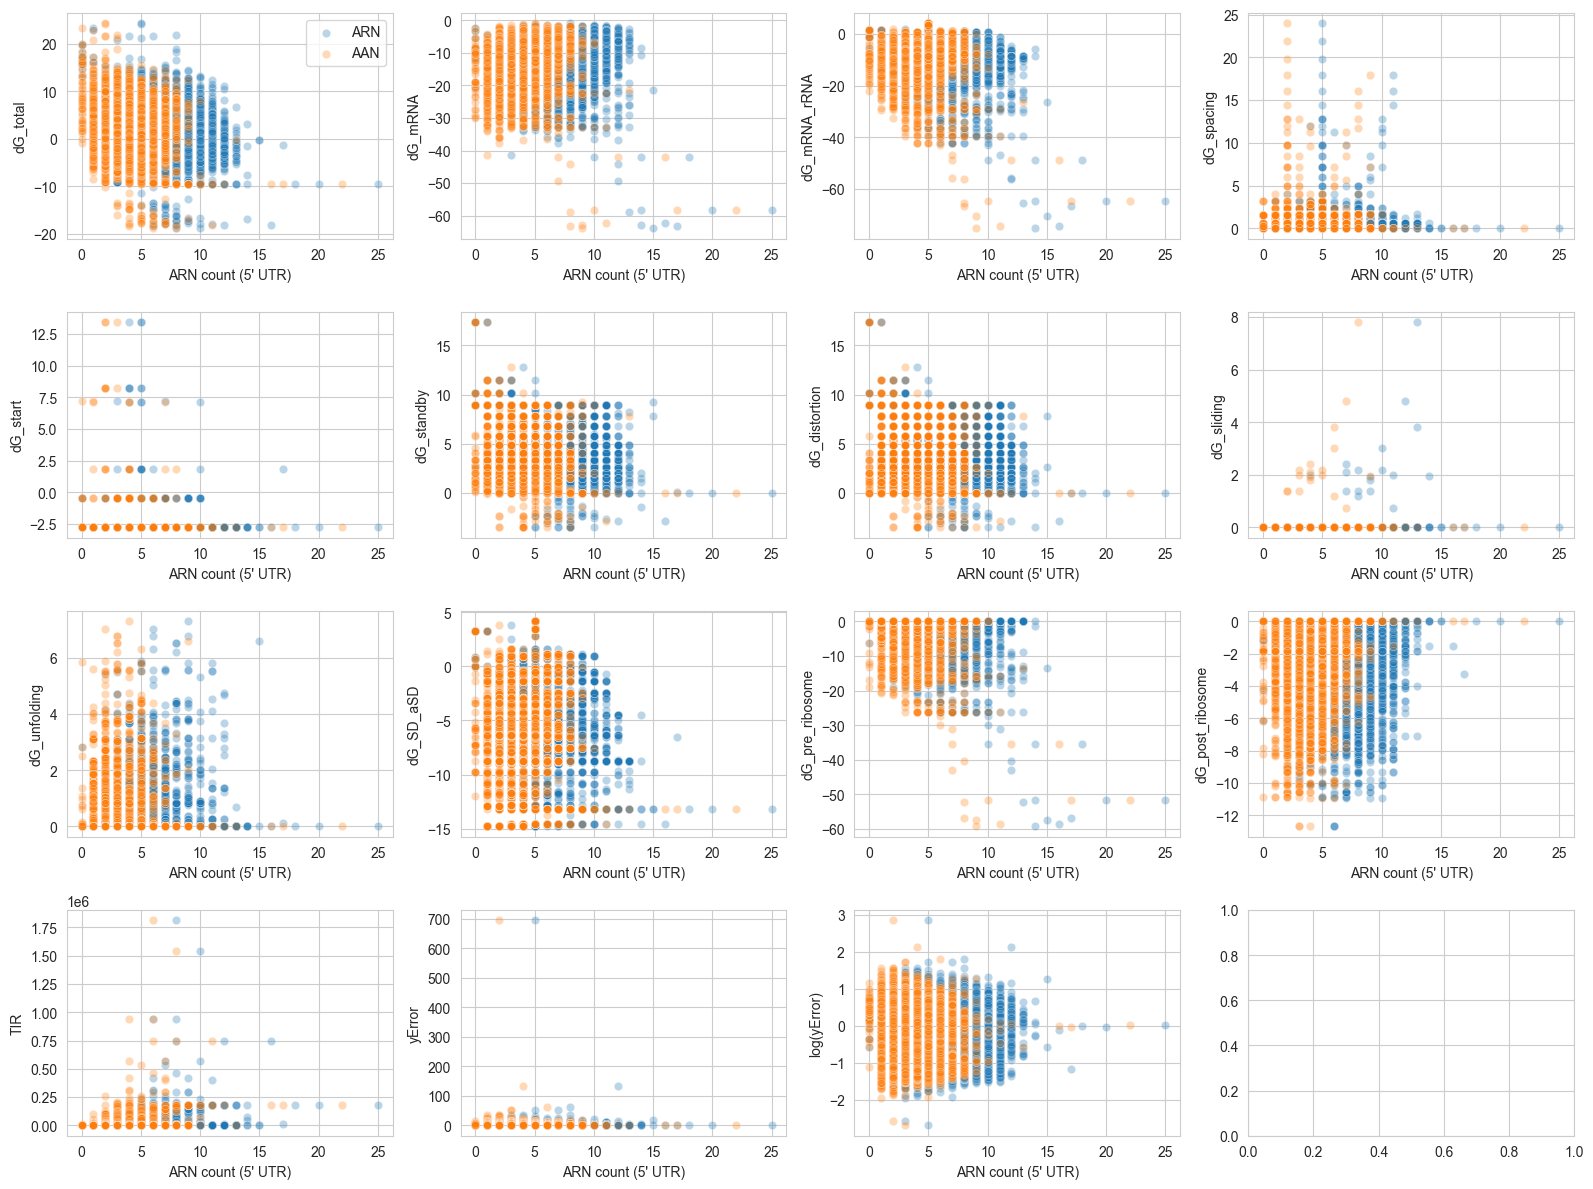

In [21]:
cols_dg = [
    col for col in df.columns if col.startswith('dG')] + [
    'TIR', 'yError', 'log(yError)']
nrows = int(np.ceil(np.sqrt(len(cols_dg))))
ncols = int(np.ceil(len(cols_dg) / nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
for i, col in enumerate(cols_dg):
    sns.scatterplot(df, x="ARN count (5' UTR)", y=col, label='ARN', # palette='coolwarm', 
                    alpha=0.3, ax=axs.flat[i], legend=True if i==0 else False)
    sns.scatterplot(df, x="AAN count (5' UTR)", y=col, label='AAN', # palette='coolwarm', 
                    alpha=0.3, ax=axs.flat[i], legend=True if i==0 else False)
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'RBS_DG_vs_ARN_count.png'), dpi=300)

In [22]:
# fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
# for i, col in enumerate(cols_dg):
#     sns.scatterplot(df, x="ARNn count (5' UTR)", y=col,
#                     alpha=0.3, ax=axs.flat[i], legend=True if i==0 else False)
# plt.tight_layout()
# plt.savefig(os.path.join(top_dir, 'RBS_DG_vs_ARNn.png'), dpi=300)

In [23]:
# cols_outs = ['Actual protein / predicted TIR', 'log Mean protein (fluo)'] 
# df['log(TIR)'] = np.log10(df['TIR'] + 1)
# g = sns.scatterplot(data=df.sort_values("ARNn count (5' UTR)"), x="dG_total", y='log(yError)', hue="ARNn count (5' UTR)", palette='viridis', alpha=1) #0.5)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

/tmp/ipykernel_1579835/3964820973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['prediction error (diff)'] = df_subset['log(TIR)'] - df_subset['log Mean protein (fluo)']
/tmp/ipykernel_1579835/3964820973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['prediction error (abs diff)'] = np.abs(df_subset['log(TIR)'] - df_subset['log Mean protein (fluo)'])
/tmp/ipykernel_1579835/3964820973.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

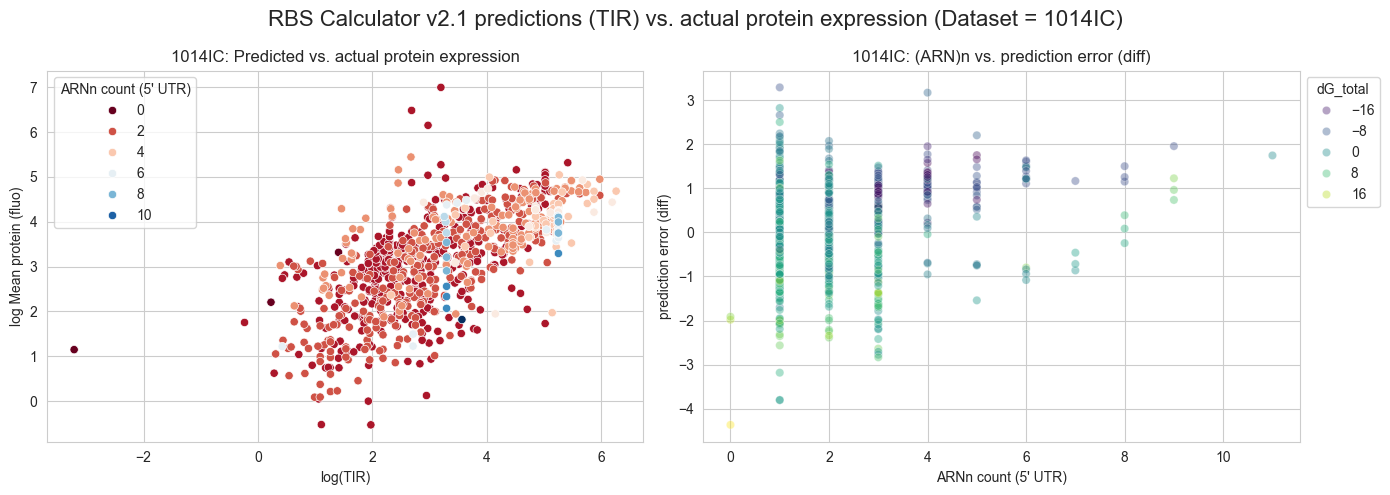

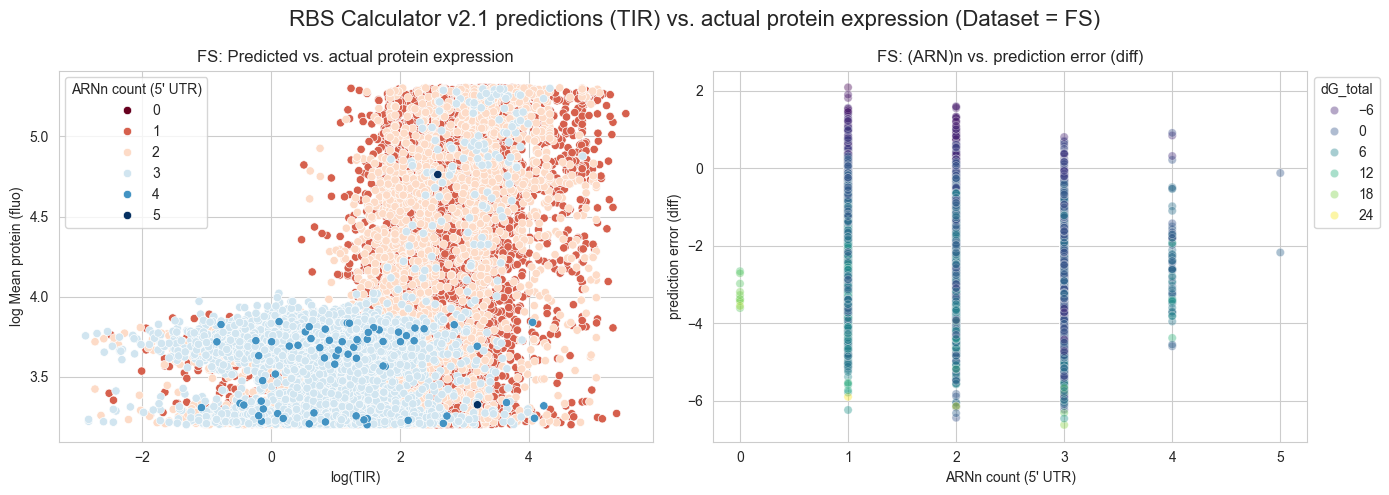

In [33]:

df['log(TIR + 1)'] = np.log10(df['TIR'] + 1)
df['log(TIR)'] = np.log10(df['TIR'])

for i, dataset_name in enumerate(df['Dataset source'].unique()):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    df_subset = df[df['Dataset source'] == dataset_name]
    sns.scatterplot(df_subset.sort_values("ARNn count (5' UTR)"), x='log(TIR)', y='log Mean protein (fluo)', hue="ARNn count (5' UTR)", 
                    palette='RdBu', alpha=1.0, ax=axs[0])
    axs[0].set_title(f'{dataset_name}: Predicted vs. actual protein expression')

    df_subset['prediction error (diff)'] = df_subset['log(TIR)'] - df_subset['log Mean protein (fluo)']
    df_subset['prediction error (abs diff)'] = np.abs(df_subset['log(TIR)'] - df_subset['log Mean protein (fluo)'])
    g = sns.scatterplot(df_subset, x="ARNn count (5' UTR)", y='prediction error (diff)', hue='dG_total', palette='viridis', alpha=0.4, ax=axs[1])
    axs[1].set_title(f'{dataset_name}: (ARN)n vs. prediction error (diff)')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    # sns.scatterplot(df_subset, x="ARNn count (5' UTR)", y='prediction error (abs diff)', hue='dG_total', palette='viridis', alpha=0.5, ax=axs[i, 2])
    # axs[i, 2].set_title(f'{dataset_name}: (ARN)n vs. prediction error (absolute diff)')
    
    plt.suptitle(f'RBS Calculator v2.1 predictions (TIR) vs. actual protein expression (Dataset = {dataset_name})', fontsize=16)

    plt.tight_layout()
    plt.savefig(os.path.join(top_dir, f'TIR_vs_Prot_{dataset_name}.png'), dpi=300)


# Examine FS dataset closer

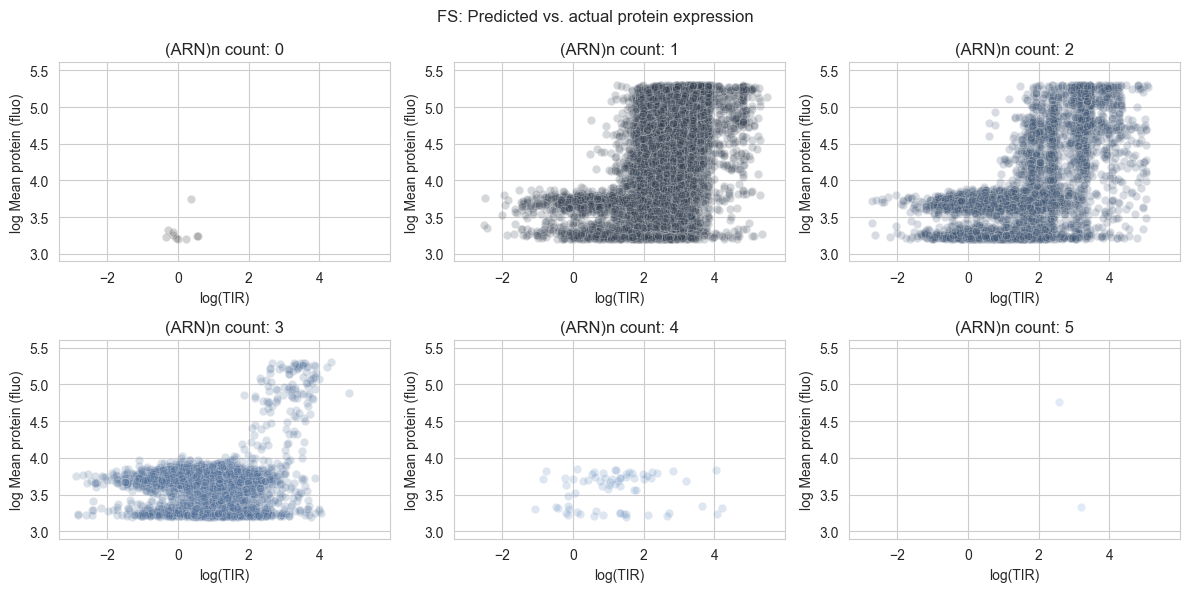

In [25]:
dataset_name = 'FS'

n_rows = 2
n_cols = int(df[df['Dataset source'] == dataset_name]["ARNn count (5' UTR)"].nunique() / n_rows)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
# sns.scatterplot(df[df['Dataset source'] == dataset_name].sort_values("ARNn count (5' UTR)"), x='log(TIR)', y='log Mean protein (fluo)', hue="ARNn count (5' UTR)", 
#                 palette='RdBu', alpha=0.7, ax=axs[0, 0])
df_subset1 = df[(df['Dataset source'] == dataset_name)]
for i, arn_count in enumerate(sorted(df_subset1["ARNn count (5' UTR)"].unique())):
    ax = axs.flat[i]
    df_subset = df_subset1[df_subset1["ARNn count (5' UTR)"] == arn_count]
    sns.scatterplot(df_subset, x='log(TIR)', y='log Mean protein (fluo)', 
                    alpha=0.2, ax=ax, color=sns.dark_palette("#69d", reverse=False, n_colors=n_cols*n_rows)[i])
    ax.set_xlabel('log(TIR)')
    ax.set_ylabel('log Mean protein (fluo)')
    ax.set_title(f'(ARN)n count: {arn_count}')
    ax.set_xlim(df_subset1['log(TIR)'].min()-0.5, df_subset1['log(TIR)'].max()+0.5)
    ax.set_ylim(df_subset1['log Mean protein (fluo)'].min()-0.3, df_subset1['log Mean protein (fluo)'].max()+0.3)
plt.suptitle(f'{dataset_name}: Predicted vs. actual protein expression')
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'FS_ARNn.png'), dpi=300)


In [26]:
# df[(df['Dataset source'] == '1014IC') & (df["ARNn count (5' UTR)"] > 6)]

In [38]:
df['PROTEIN'].unique(), df_FS['DATASET'].unique()

(array(['RFP', 'mRFP', 'luciferase', 'mRFP1', 'sGFP', 'LacZ', 'RFP-GFP',
        'CFP-RFP-GFP', 'NanoLuc', 'sfGFP', 'GFP', 'LacZ-fusion'],
       dtype=object),
 array(['Kosuri_PNAS_2013', 'Goodman_Science_2013'], dtype=object))

In [28]:
df_FS['Promoter ID'] = df_FS['PROMOTER'].apply(lambda x: dict(
    zip(df_FS['PROMOTER'].unique(), np.arange(df_FS['PROMOTER'].nunique())))[x])
df_FS['RBS ID'] = df_FS['RBS'].apply(lambda x: dict(
    zip(sorted(df_FS['RBS'].unique()), np.arange(df_FS['RBS'].nunique())))[x])
cols_exclude = ['log(TIR)', 'log Mean protein (fluo)',
                'ORGANISM', 'PLASMID', 'TEMP', 'PROTEIN',
                'PROMOTER', '5pUTR', '5pUTR.1', 'RBS',
                'N.TERMINAL.CDS', 'CDS', 'CDS.1', 'SEQUENCE', 'BIN1',
                'BIN2', 'BIN3', 'BIN4', 'BIN5', 'BIN6', 'BIN7', 'BIN8', 'BIN9', 'BIN10',
                'BIN11', 'BIN12', 'COUNT.PROTEIN', 'Mean protein (fluo)', 'PROT.VAR',
                'PROT.STD', 'COUNT.A.DNA', 'COUNT.B.DNA', 'COUNT.DNA', 'COUNT.A.RNA',
                'COUNT.B.RNA', 'COUNT.RNA', 'RNA.A', 'RNA.B', 'RNA', 'RNA.VAR',
                'RNA.STD', 'TRANSL.RATE', 'TRANSL.RATE.VAR', 'TRANSL.RATE.STD',
                'dG_total', 'dG_mRNA', 'dG_mRNA_rRNA', 'dG_spacing', 'dG_start',
                'dG_standby', 'dG_distortion', 'dG_sliding', 'dG_unfolding',
                'dG_SD_aSD', 'dG_pre_ribosome', 'dG_post_ribosome', 'initial_fold',
                'spacing', 'position', 'predicted_UTR', 'predicted_CDS', 'yPredicted',
                'yError', 'Dataset source',
                'used_mRNA_sequence', 'predicted_5pUTR_2.0', 'predicted_CDS_2.0', 'TIR',
                'Actual protein / predicted TIR', "ARN count (5' UTR)",
                "AAN count (5' UTR)", "ARNn count (5' UTR)", 'log(yError)'
                ]

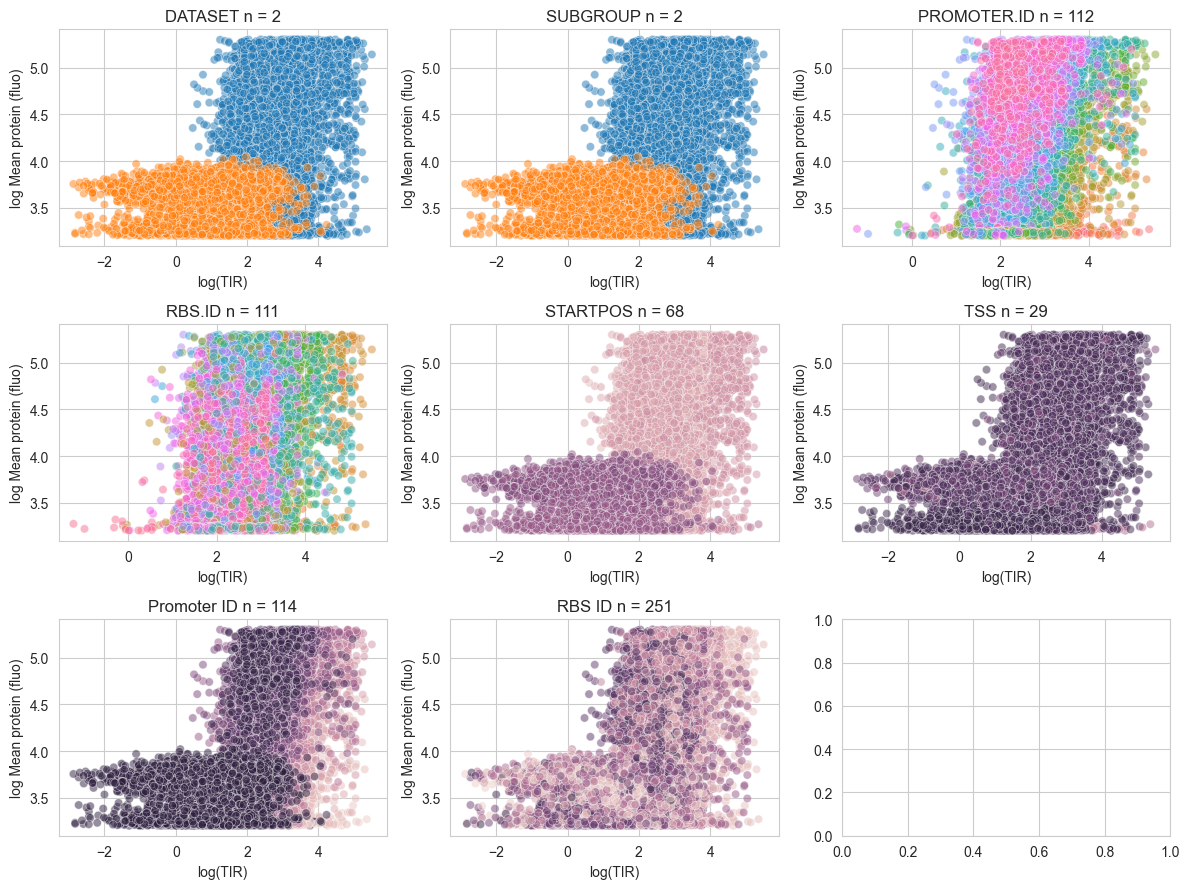

In [29]:
cols_hue = [c for c in df_FS.columns if c not in cols_exclude]
n_cols = int(np.sqrt(len(cols_hue))) + 1
n_rows = int(np.sqrt(len(cols_hue))) + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

df_FS['log(TIR)'] = np.log10(df_FS['TIR'])

for i, c in enumerate(cols_hue):

    sns.scatterplot(df_FS, x='log(TIR)', y='log Mean protein (fluo)', hue=c, alpha=0.5, ax=axs.flat[i],
                    legend=False)
    axs.flat[i].set_title(c + ' n = ' + str(df_FS[c].nunique()))

plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'FS_hues.png'), dpi=300)


['ctgacagctagctcagtcctaggtataatgctagcCACCG'
 'ttgacggctagctcagtcctaggtacagtgctagcTTAAT']


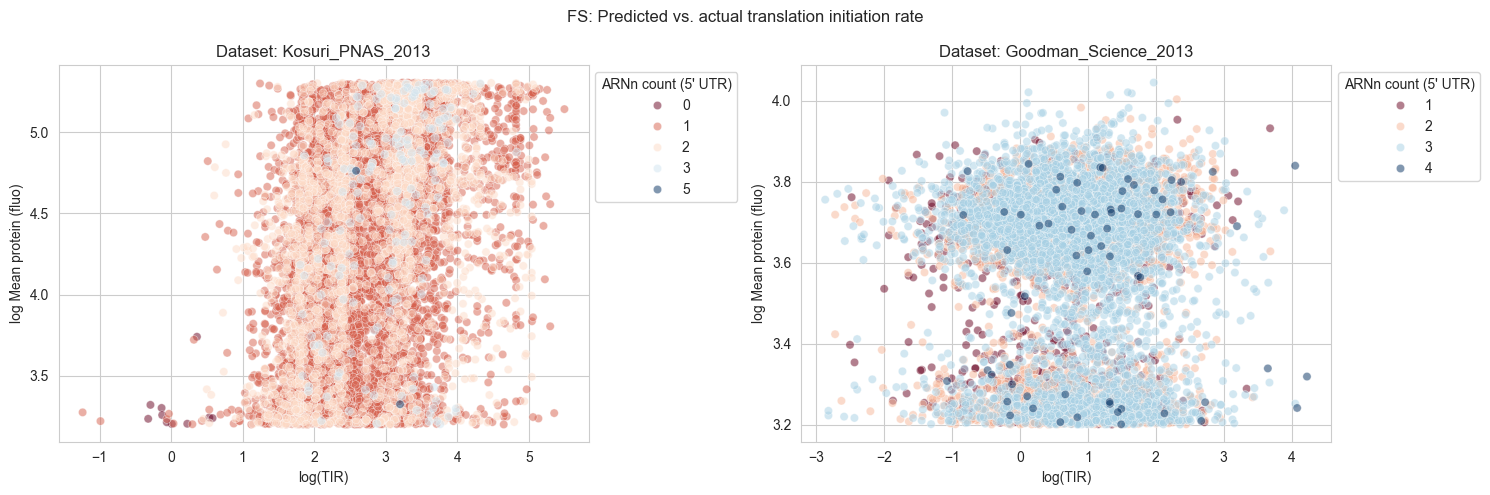

In [30]:
fig, axs = plt.subplots(1, df_FS['DATASET'].nunique(), figsize=(15, 5))
df_FS['log(TIR + 1)'] = np.log10(df_FS['TIR'] + 1)
for i, dataset_type in enumerate(df_FS['DATASET'].unique()):
    df_subset = df_FS[df_FS['DATASET'] == dataset_type]
    g = sns.scatterplot(df_subset.sort_values("ARNn count (5' UTR)"), x='log(TIR)', y='log Mean protein (fluo)', 
                    hue="ARNn count (5' UTR)",
                    alpha=0.5, ax=axs[i], palette='RdBu')
    axs[i].set_title('Dataset: ' + dataset_type)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.suptitle('FS: Predicted vs. actual translation initiation rate')
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'FS_dataset_split.png'), dpi=300)
    
print(df_FS[df_FS['DATASET'] == 'Goodman_Science_2013']['PROMOTER'].unique())

/tmp/ipykernel_1579835/1738119202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FS_subset['log(TIR)'] = np.log10(df_FS_subset['TIR'])


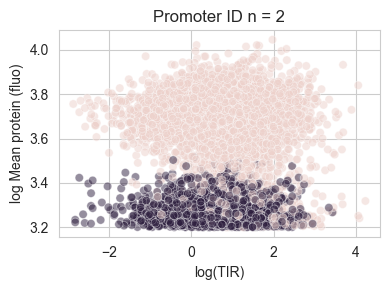

In [42]:
df_FS_subset = df_FS[df_FS['DATASET'] == 'Goodman_Science_2013']

# cols_hue = [c for c in df_FS_subset.columns if c not in cols_exclude] + [
#      "ARN count (5' UTR)", "AAN count (5' UTR)", "ARNn count (5' UTR)", 
#      'log(yError)', 'Actual protein / predicted TIR',
#      'BIN1', 'BIN2', 'BIN3', 'BIN4', 'BIN5', 'BIN6', 'BIN7', 'BIN8', 'BIN9', 'BIN10', 'BIN11', 'BIN12',
#      'COUNT.PROTEIN', 'PROT.STD', 'TRANSL.RATE', 'TRANSL.RATE.STD', 'dG_total', 'spacing',
#      'yPredicted',
#      'COUNT.A.DNA', 'COUNT.B.DNA', 'COUNT.DNA', 'COUNT.A.RNA', 'COUNT.B.RNA', 'COUNT.RNA',
#      'RNA.A', 'RNA.B', 'RNA', 'RNA.STD', 
# ]
cols_hue = ['Promoter ID']
n_cols = int(np.sqrt(len(cols_hue)))
n_rows = int(np.sqrt(len(cols_hue)))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

df_FS_subset['log(TIR)'] = np.log10(df_FS_subset['TIR'])

for i, c in enumerate(cols_hue):

    sns.scatterplot(df_FS_subset, x='log(TIR)', y='log Mean protein (fluo)', hue=c, alpha=0.5, ax=axs,
                    legend=False)
    axs.set_title(c + ' n = ' + str(df_FS_subset[c].nunique()))

plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'FS_Goodman_split.png'), dpi=300)


# Fit line to 1014IC data

['TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAAAAAAAAAAAAATAAGGAGGTAAAAAATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaagttcgtatggaaggttccgttaacggtcacgagttcgaaatcgaaggtgaaggtgaa'
 'TCTAGAGGCCGACGCAAGATATCGCTTCCGTCGGCCAAAAAAAAAAATAAGGAGGTAAAAAATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaagttcgtatggaaggttccgttaacggtcacgagttcgaaatcgaaggtgaaggtgaa'
 'TCTAGAGGCCGACGCAAGATATCGCTTCCGTCGGCCAAAAAAAAAAAAAATAAGGAGGTAAAAAATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaagttcgtatggaaggttccgttaacggtcacgagttcgaaatcgaaggtgaaggtgaa'
 'TCTAGAGGCCGACGCAAGATATCGCTTCCGTCGGCCAAAAAAAAAAAAAAATAAGGAGGTAAAAAATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaagttcgtatggaaggttccgttaacggtcacgagttcgaaatcgaaggtgaaggtgaa'
 'TCTAGAGGCCGACGCAAGATATCGCTTCCGTCGGCCAAAAAAAAAAAAAAAATAAGGAGGTAAAAAATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaagttcgtatggaaggttccgttaacggtcacgagttcgaaatcgaaggtgaaggtgaa'
 'TCTAGAGGCCGACGCAAGATATCGCTTCCGTCGGCCAAAAAAAAAAAAAAAAATAAGGAGGTAAAAAATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaagttcgtatggaaggttccgttaacggtca

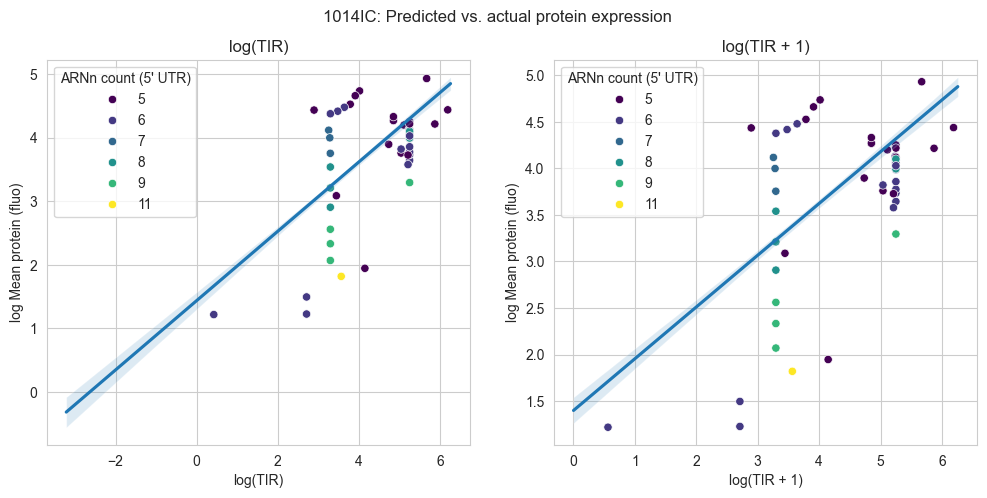

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(df[(df['Dataset source'] == '1014IC') & (df["ARNn count (5' UTR)"] > 4)], 
                x='log(TIR)', y='log Mean protein (fluo)', hue="ARNn count (5' UTR)", 
                palette='viridis', alpha=1.0, ax=axs[0])
axs[0].set_title('log(TIR)')
sns.regplot(df[df['Dataset source'] == '1014IC'], x='log(TIR)', y='log Mean protein (fluo)', ax=axs[0], scatter=False)
sns.scatterplot(df[(df['Dataset source'] == '1014IC') & (df["ARNn count (5' UTR)"] > 4)], 
                x='log(TIR + 1)', y='log Mean protein (fluo)', hue="ARNn count (5' UTR)", 
                palette='viridis', alpha=1.0, ax=axs[1])
axs[1].set_title('log(TIR + 1)')
sns.regplot(df[df['Dataset source'] == '1014IC'], x='log(TIR + 1)', y='log Mean protein (fluo)', ax=axs[1], scatter=False)
plt.suptitle('1014IC: Predicted vs. actual protein expression')
plt.savefig(os.path.join(top_dir, '1014IC_replot.png'), dpi=300)

print(df[(df['Dataset source'] == '1014IC') & (df["ARNn count (5' UTR)"] > 4)]['SEQUENCE'].unique())